Objective: \nu_{pk} and F_{pk} from hydro parameters and as little additional free parameters as possible

In [1]:
from fit_Fvsnu_pk import * 
from scipy.integrate import quad
from scipy.optimize import brentq
from IPython.core.magic import register_cell_magic
import time

@register_cell_magic
def skip(line, cell):
    return

c_    = 2.99792458e10           # cm/s: light speed 
mp_   = 1.67262192e-24          # g: proton mass
Msun_ = 1.9891e33               # g: solar mass
pi_   = np.pi
e_    = 4.80320425e-10          # Fr (cm^3/2 g^1/2 s^-1): charge unit
me_   = 9.10938291e-28          # g: electron mass

# psyn, eps_e, eps_B, xi_e, z, d_L
assumptions = [2.5, 1./3., 1./3., 1e-2, 1., 2e28]

In [ ]:
def compute_quantities(env):
    '''Compute g, nu_0, F_0 from model parameters'''
    # Derived velocities and Lorentz factors
    env.beta1 = env.u1 / np.sqrt(1 + env.u1**2)
    env.lfac1 = np.sqrt(1 + env.u1**2)
    env.beta4 = env.u4 / np.sqrt(1 + env.u4**2)
    env.lfac4 = np.sqrt(1 + env.u4**2)
    
    # Rescale radial widths in cm
    env.D01 = env.D01 * env.R0
    env.D04 = env.D04 * env.R0

    # Collision time
    env.t0 = env.R0 / (env.beta4 * c_)
    
    # Lab-frame densities (at collision)
    env.V1 = 4*pi_ * env.R0**2 * env.D01
    env.rho1 = (env.Ek1 / (env.lfac1 - 1)) / (env.V1 * c_**2 * env.lfac1)
    
    env.V4 = 4*pi_ * env.R0**2 * env.D04
    env.rho4 = (env.Ek4 / (env.lfac4 - 1)) / (env.V4 * c_**2 * env.lfac4)
    
    # Proper density ratio
    env.f = env.rho4 / env.rho1
    
    # Shocked material proper speed (in frame 1)
    env.lfac41 = env.lfac1 * env.lfac4 - env.u1 * env.u4
    env.u41 = np.sqrt(env.lfac41**2 - 1)
    fac = np.sqrt((2*env.f**(3/2)*env.lfac41 - env.f*(1+env.f)) / (2*env.f*(env.u41**2 + env.lfac41**2) - (1 + env.f**2)))
    env.u21 = env.u41 * fac
    
    # Shock strengths (relative Lorentz factors)
    env.lfac21 = np.sqrt(1 + env.u21**2)
    env.u34 = env.u21 / np.sqrt(env.f)
    env.lfac34 = np.sqrt(1 + env.u34**2)
    
    # Shocked material speed (lab frame)
    env.beta21 = env.u21 / env.lfac21
    env.u0 = env.lfac21 * env.lfac1 * (env.beta21 + env.beta1)
    env.lfac0 = np.sqrt(1 + env.u0**2)
    env.beta0 = env.u0 / env.lfac0
    
    # Shock front velocities
    env.betaRS = (env.beta4 - 4*env.lfac34*(env.u0/env.lfac4)) / (1 - 4*env.lfac34*(env.lfac0/env.lfac4))
    env.lfacRS = 1 / np.sqrt(1 - env.betaRS**2)
    env.betaFS = ((0.25/env.lfac21)*(env.u1/env.lfac0) - env.beta0) / ((0.25/env.lfac21)*(env.lfac1/env.lfac0) - 1)
    env.lfacFS = 1 / np.sqrt(1 - env.betaFS**2)

    # Theoretical crossing radii (constant velocities)
    env.Rf_RS = env.R0 + env.D04 * env.betaRS / (c_ * (env.beta4 - env.betaRS))
    env.Rf_FS = env.R0 + env.D01 * env.betaFS / (c_ * (env.betaFS - env.beta1))
    
    # g parameter (Γ/Γ_sh ratios)
    env.g_RS = env.lfac0 / env.lfacRS
    env.g_FS = env.lfac0 / env.lfacFS
    
    # Comoving internal energy densities
    env.eint3p = 4 * env.lfac34 * (env.lfac34 - 1) * env.rho4 * c_**2
    env.eint2p = 4 * env.lfac21 * (env.lfac21 - 1) * env.rho1 * c_**2
    
    # Comoving magnetic field
    env.B3p = np.sqrt(8*pi_* env.eps_B * env.eint3p)
    env.B2p = np.sqrt(8*pi_* env.eps_B * env.eint2p)
    
    # Electron Lorentz factors
    Gp = (env.psyn - 2) / (env.psyn - 1)
    env.gma_m_RS = (mp_/me_) * Gp * (env.eps_e/env.xi_e) * (env.lfac34 - 1)
    env.gma_m_FS = (mp_/me_) * Gp * (env.eps_e/env.xi_e) * (env.lfac21 - 1)
    
    # Comoving peak frequency
    env.nuBp_RS = e_ * env.B3p / (2*pi_ * me_ * c_)
    env.nu0p_RS = env.gma_m_RS**2 * env.nuBp_RS
    env.nuBp_FS = e_ * env.B2p / (2*pi_ * me_ * c_)
    env.nu0p_FS = env.gma_m_FS**2 * env.nuBp_FS
    
    # Observed peak frequencies (ν_0)
    env.nu0_RS = 2 * env.lfac0 * env.nu0p_RS / (1 + env.z)
    env.nu0_FS = 2 * env.lfac0 * env.nu0p_FS / (1 + env.z)
    
    # Comoving bolometric luminosities
    env.Lbolp_RS = (4/3) * env.eps_e * (4*pi_*env.R0**2) * c_**3 * (env.lfac34-1) * env.u34 * env.rho4
    env.Lbolp_FS = (4/3) * env.eps_e * (4*pi_*env.R0**2) * c_**3 * (env.lfac21-1) * env.u21 * env.rho1
    
    # Comoving peak luminosity
    Wp = 2 / Gp
    env.L0p_RS = env.Lbolp_RS / (Wp * env.nu0p_RS)
    env.L0p_FS = env.Lbolp_FS / (Wp * env.nu0p_FS)
    
    # Observed peak flux normalization
    env.L0_RS = 2 * env.lfac0 * env.L0p_RS
    env.Fs_RS = (1 + env.z) / (4*pi_ * env.d_L**2) * env.L0_RS
    env.F0_RS = env.Fs_RS / 3
    env.nu0F0_RS = env.nu0_RS*env.F0_RS
    env.L0_FS = 2 * env.lfac0 * env.L0p_FS
    env.Fs_FS = (1 + env.z) / (4*pi_ * env.d_L**2) * env.L0_FS
    env.F0_FS = env.Fs_FS / 3
    env.nu0F0_FS = env.nu0_FS*env.F0_FS

    # Observed time normalizations (angular times related to shock fronts)
    env.T0_RS = (1+z) * (env.R0/c_) * ((1-env.betaRS)/env.betaRS)
    env.T0_FS = (1+z) * (env.R0/c_) * ((1-env.betaFS)/env.betaFS)


In [3]:
class MyEnv:
    def __init__(self, shells_params, assumptions):
        # model params:
        # D0_1/R_0, u_1, Ek_1, D0_4/R_0, u_4, R_0
        # assumptions:
        # psyn, eps_e, eps_B, xi_e, z, d_L
        
        self.read_params(shells_params, assumptions)
        compute_quantities(self)
        
    def read_params(self, shells_params, assumptions):
        '''Set parameter values in the class'''
        names = ['D01', 'u1', 'Ek1', 'D04', 'u4', 'Ek4', 'R0']
        for name, value in zip(names, shells_params):
            setattr(self, name, value)
        names = ['psyn', 'eps_e', 'eps_B', 'xi_e', 'z', 'd_L']
        for name, value in zip(names, assumptions):
            setattr(self, name, value)


In [4]:
def smooth_BPL(x, X_sph, alpha, beta, s=1.0):
    """
    Smooth broken power-law, normalized (X(1)=1)
    X(R) = [(X_pl * x^alpha)^s + (X_sph * x^beta)^s]^(1/s)
    
    Args:
        x ≥ 1.0
        X_sph: Amplitude for spherical (large-R) regime (normalized)
        alpha: Power-law index at small R (R → 1)
        beta: Power-law index at large R (R → ∞)
        s: Blending sharpness (smaller = smoother transition)
    """
    
    s *= np.sign(beta-alpha)
    X_pl = (1-X_sph**s)**(1.0/s)
    term_pl = np.abs(X_pl * (x**alpha))**s
    term_sp = np.abs(X_sph * (x**beta))**s
    return np.sign(X_pl) * (term_pl + term_sp)**(1.0/s)

def scaling_functions(r, m, n, Gamma_sph, Sh_sph):
    '''f_Gamma, f_nu', f_L' with r = R/R_0'''
    
    alpha_G, a, d = -0.5*m, 1.0 + 1.5*n, -(1.0 + 2.5*n)
    nu_sph = Sh_sph**(1.5)
    L_sph = 1/np.sqrt(Sh_sph)
    Gamma_d = smooth_BPL(r, Gamma_sph, alpha_G, 0.0, s)
    nu_prime = smooth_BPL(r, nu_sph, d, -1.0, s)
    L_prime = smooth_BPL(r, L_sph, a, 1.0, s)
    return Gamma_d, nu_prime, L_prime

def angles_and_radius(T, g, m, k_xi, xi_sat, s):
    g2 = g**2
    EATS = g2 * (T - 1.0)
    xi_max = (EATS**(-s) + xi_sat**(-s))**(-1.0/s)
    xi_eff = k_xi * xi_max
    m_for_y = m if abs(m) > 1e-8 else 0.0
    y_eff = (1.0 + (m_for_y + 1.0) * xi_eff / g2)**(-1.0/(m_for_y + 1.0))
    r_eff = y_eff*T
    return xi_eff, xi_max, r_eff

def logslope(r, x):
    logr, logx = np.log10(r), np.log10(x)
    slope = np.gradient(logx, logr)
    return slope

In [5]:
# Find the final crossing radius, knowing the function for \Gamma(R)
def func_Gamma(r, m, Gamma_0, Gamma_sph, g, s):
    '''Gamma_sh as a function of r=R/R0'''
    Gamma_d = Gamma_0*smooth_BPL(r, Gamma_sph, -0.5*m, 0.0, s)
    return Gamma_d/g

def integrand(r, beta_i, m, Gamma_0, Gamma_sph, g, s, reverse):
    Gamma_sh = func_Gamma(r, m, Gamma_0, Gamma_sph, g, s)
    beta_sh = np.sqrt(1. - 1/(Gamma_sh*Gamma_sh))
    if reverse:     # RS
        integrand = 1.0 - beta_sh / beta_i
    else:           # FS
        integrand = 1.0 - beta_i / beta_sh
    return integrand

def cumulative(R, R0, beta_i, m, Gamma_0, Gamma_sph, g, s, reverse):
    if R <= R0:
        return 0.
    val, _ = quad(integrand, R0, R, args=(beta_i, m, Gamma_0, Gamma_sph, g, s, reverse))
    return val

def func_root(R, D0, R0, beta_i, m, Gamma_0, Gamma_sph, g, s, reverse):
    return cumulative(R, R0, beta_i, m, Gamma_0, Gamma_sph, g, s, reverse) - D0

# final radius of the shock front
def crossing_radius(Rf_th, D0, R0, beta_i, m, Gamma_0, Gamma_sph, g, s, reverse):
    '''
    Computes the final crossing radius for a shock front
    Rf_th is the theoretical expectation from constant velocity
    '''

    # find an upper limit
    R_up = Rf_th
    while func_root(R_up, D0, R0, beta_i, m, Gamma_0, Gamma_sph, g, s, reverse) <= 0.:
        R_up *= 1.5
    
    Rf = brentq(func_root, R0, R_up, args=(D0, R0, beta_i, m, Gamma_0, Gamma_sph, g, s, reverse))
    return Rf

In [33]:
def pks_from_params(T, fit_params, assumptions, 
    front='RS', force_los=False, noHLE=False):
    '''
    Compute nu_pk(T) and (F_nu)_pk(T) for chosen front from fitting parameters
    T normalized (tilde{T} in R24a,b & C25)
    force_los sets the effective angle to 0
    Approximate HLE tail added with self-consistent \nu_bk derivation
    fit_params: 
        D0_1:           Radial width of shell 1, in units R_0
        u_1:            Proper velocity of shell 1
        Ek_1:           Kinetic energy of shell 1
        D0_4:           Radial width of shell 4, in units R_0
        u_4:            Proper velocity of shell 4
        Ek_4:           Kinetic energy of shell 4
        R_0:            Collision radius
        m:              Power-law index of Gamma_d
        n:              Power-law index of (Gamma_ud - 1)
        Gamma_sph, Sh_sph:
            R>>1 term of smooth_BPL, in units the value at R_0
        k_xi:           Effective angle/maximal_angle, free parameter
        xi_sat:         Saturation value of effective angle on the EATS (due to beaming)
        s:              Smoothing parameter
    '''
    shells_params = fit_params[:7]
    (m, n, 
     Gamma_sph, Sh_sph,
     k_xi, xi_sat, s) = fit_params[7:]
    env = MyEnv(shells_params, assumptions)
    R0, lfac0 = env.R0, env.lfac0
    shell = '4' if (front == 'RS') else '1'
    D0, beta_i = [getattr(env, name+shell) for name in ['D0', 'beta']]
    frontParams = ['g', 'Rf', 'nu0', 'Fs']
    g, Rf_th, nu0, Fs = [getattr(env, name+'_'+front) for name in frontParams]
    g2 = g**2
    alpha_G = -m/2.0
    a, d = 1.0 + 1.5*n, -(1.0 + 2.5*n)
    nu_sph = Sh_sph**(1.5)
    L_sph = 1/np.sqrt(Sh_sph)

    # Time at crossing
    reverse = True if (front == 'RS') else False
    Rf = crossing_radius(Rf_th, D0, R0, beta_i, m, lfac0, Gamma_sph, g, s, reverse)
    Tf = Rf/R0

    def eff_xi_and_y(T, force_los):
        # Maximal and effective emission angle
        EATS = g2 * (T - 1.0)
        xi_max = (EATS**(-s) + xi_sat**(-s))**(-1.0/s)
        if force_los:
            xi_eff, y_eff = 0., 1.
        else:
            xi_eff = k_xi * xi_max
            m_for_y = m if abs(m) > 1e-8 else 0.0
            y_eff = (1.0 + (m_for_y + 1.0) * xi_eff / g2)**(-1.0/(m_for_y + 1.0))
        return xi_max, xi_eff, y_eff
    
    def nu_Fnu_rise(T):
        xi_max, xi_eff, y_eff = eff_xi_and_y(T, force_los)
        
        # LF, comoving frequency, and luminosity at effective radius, normalized
        r_eff = y_eff*T
        Gamma_d = smooth_BPL(r_eff, Gamma_sph, alpha_G, 0.0, s)
        Gamma_d_RL = smooth_BPL(T, Gamma_sph, alpha_G, 0.0, s)
        nu_prime = smooth_BPL(r_eff, nu_sph, d, -1.0, s)
        L_prime = smooth_BPL(r_eff, L_sph, a, 1.0, s)

        # peak frequency and flux (up to crossing time)
        G_Dop =  Gamma_d / (1 + xi_eff)
        nu_pk = nu0 * G_Dop * nu_prime
        F_nu_pk = Fs * g2 * xi_max * (G_Dop**3) * L_prime / (Gamma_d_RL**2)
        return nu_pk, F_nu_pk
    
    def nu_Fnu_HLE(T):
        nu_pkf, F_nu_pkf = nu_Fnu_rise(Tf)
        _, _, y_eff = eff_xi_and_y(Tf, force_los)
        r_f = y_eff * Tf
        Gamma_f = smooth_BPL(r_f, Gamma_sph, alpha_G, 0.0, s)
        # Gamma_f is already in units lfac0
        T_hle  = 1. + (T - 1.) * (Gamma_f**2)
        T_hle0 = 1. + (Tf - 1.) * (Gamma_f**2)
        T_hle /= T_hle0
        nu_pk = nu_pkf / T_hle
        F_nu_pk = F_nu_pkf / (T_hle**2)
        return nu_pk, F_nu_pk
    
    if noHLE:
        nu_pk, F_nu_pk = nu_Fnu_rise(T)
    else:
        nu_pk, F_nu_pk = np.where(T<=Tf, nu_Fnu_rise(T), nu_Fnu_HLE(T))

    return nu_pk, F_nu_pk


In [ ]:
shells_params = [
    3.75e-5, 100, 1e52, # D01, u1, Ek1
    3.75e-5, 200, 1e52, # D04, u4, Ek4
    8.0e13]             # R0
fit_params = [
    *shells_params,
    -0.3, 0.65,         # m, n
    1.08, 0.7,          # Gamma_sph, Sh_sph
    0.3, 7.0, 2.0       # k_xi, xi_sat, s
]
env = MyEnv(shells_params, assumptions)
(m, n, 
 Gamma_sph, Sh_sph,
 k_xi, xi_sat, s) = fit_params[7:]


/tmp/ipykernel_222356/2245943665.py:34: RuntimeWarning: divide by zero encountered in power
  xi_max = (EATS**(-s) + xi_sat**(-s))**(-1.0/s)


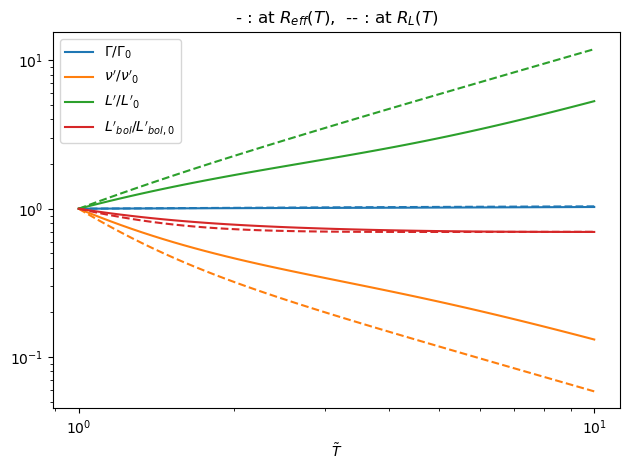

In [65]:
r = np.geomspace(1, 10)
xi_eff, xi_max, r_eff = angles_and_radius(r, env.g_RS, m, k_xi, xi_sat, 2)

vals_los = scaling_functions(r, m, n, Gamma_sph, Sh_sph)
vals_los = [*vals_los, vals_los[1]*vals_los[2]]
vals_xieff = scaling_functions(r_eff, m, n, Gamma_sph, Sh_sph)
vals_xieff = [*vals_xieff, vals_xieff[1]*vals_xieff[2]]
names = ["$\\Gamma/\\Gamma_0$", "$\\nu'/\\nu'_0$", "$L'/L'_0$", "$L'_{bol}/L'_{bol,0}$"]
cols = ['C0', 'C1', 'C2', 'C3']
for val_los, val_eff, name, c in zip(vals_los, vals_xieff, names, cols):
    plt.loglog(r, val_eff, c=c, label=name)
    plt.loglog(r, val_los, c=c, ls='--')
plt.xlabel('$\\tilde{T}$')
plt.title('- : at $R_{eff}(T)$,  -- : at $R_L(T)$')
plt.legend()
plt.tight_layout()

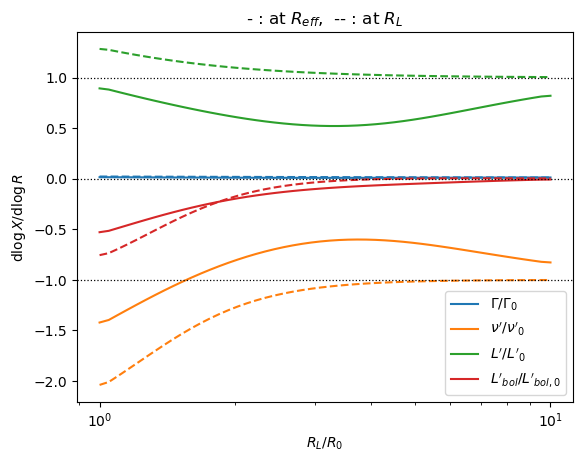

In [32]:
slopes_los = [logslope(r, val) for val in vals_los]
slopes_eff = [logslope(r, val) for val in vals_xieff]

for val_los, val_eff, name, c in zip(slopes_los, slopes_eff, names, cols):
    plt.semilogx(r, val_eff, c=c, label=name)
    plt.semilogx(r, val_los, c=c, ls='--')
plt.xlabel('$R_L/R_0$')
plt.ylabel("d$\\log X/$d$\\log R$")
plt.title('- : at $R_{eff}$,  -- : at $R_L$')
plt.legend()
for y in [-1, 0, 1]: 
    plt.axhline(y, ls=':', c='k', lw=.9)
plt.legend(loc='lower right')

/tmp/ipykernel_222356/2245943665.py:34: RuntimeWarning: divide by zero encountered in power
  xi_max = (EATS**(-s) + xi_sat**(-s))**(-1.0/s)


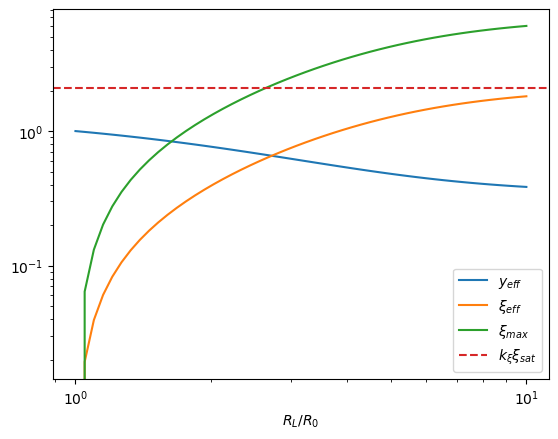

In [30]:
r = np.geomspace(1, 10)
xi_eff, xi_max, r_eff = angles_and_radius(r, env.g_RS, m, k_xi, xi_sat, 2)
plt.loglog(r, r_eff/r, label='$y_{eff}$')
plt.loglog(r, xi_eff, label='$\\xi_{eff}$')
plt.loglog(r, xi_max, label='$\\xi_{max}$')
plt.axhline(k_xi*xi_sat, ls='--', c='C3', label='$k_\\xi\\xi_{sat}$')
plt.xlabel('$R_L/R_0$')
plt.legend()

In [36]:
T = np.geomspace(1, 10, 200)
nu0, nu0F0 = env.nu0_RS, env.nu0F0_RS
nu_pk, F_nu_pk = pks_from_params(T, fit_params, assumptions)
nu_pk_noHLE, F_nu_pk_noHLE = pks_from_params(T, fit_params, assumptions, noHLE=True)
nu_pk_los, F_nu_pk_los = pks_from_params(T, fit_params, assumptions, force_los=True)
x_eff, x_los, x_noHLE = nu_pk/nu0, nu_pk_los/nu0, nu_pk_noHLE/nu0
nF_eff, nF_los, nF_noHLE = nu_pk*F_nu_pk/nu0F0, nu_pk_los*F_nu_pk_los/nu0F0, nu_pk_noHLE*F_nu_pk_noHLE/nu0F0


/tmp/ipykernel_222356/3791293432.py:48: RuntimeWarning: divide by zero encountered in power
  xi_max = (EATS**(-s) + xi_sat**(-s))**(-1.0/s)


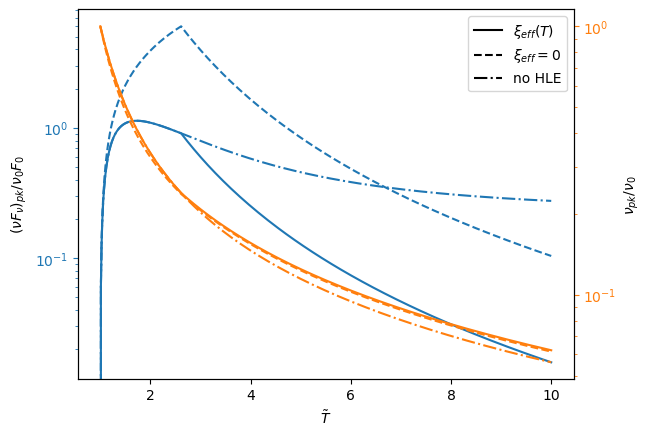

In [66]:

plt.loglog(T, nF_eff, c="C0")
plt.loglog(T, nF_los, c="C0", ls='--')
plt.loglog(T, nF_noHLE, c="C0", ls='-.')
plt.xlabel('$\\tilde{T}$')
plt.ylabel('$(\\nu F_\\nu)_{pk}/\\nu_0F_0$')
plt.tick_params(which='both',axis='y', colors='C0')
ax2 = plt.twinx()
ax2.set_ylabel("$\\nu_{pk}/\\nu_0$")
ax2.loglog(T, x_eff, color='C1')
ax2.loglog(T, x_los, color='C1', ls='--')
ax2.loglog(T, x_noHLE, color='C1', ls='-.')
plt.tick_params(which='both',axis='y', colors='C1')
plt.plot([],[],c='k',label='$\\xi_{eff}(T)$')
plt.plot([],[],c='k', ls='--', label='$\\xi_{eff}=0$')
plt.plot([],[],c='k', ls='-.', label='no HLE')
plt.legend(loc='upper right')
plt.xscale('linear')

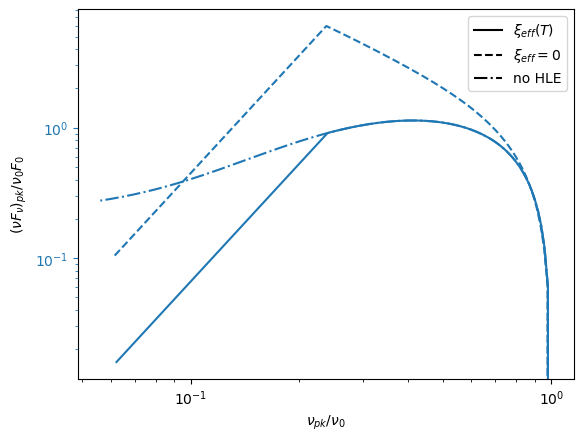

In [39]:

plt.loglog(x_eff, nF_eff, c='C0')
plt.loglog(x_los, nF_los, c='C0', ls='--')
plt.loglog(x_noHLE, nF_noHLE, c='C0', ls='-.')
plt.xlabel('$\\nu_{pk}/\\nu_0$')
plt.ylabel('$(\\nu F_\\nu)_{pk}/\\nu_0F_0$')
plt.tick_params(which='both',axis='y', colors='C0')
plt.plot([],[],c='k',label='$\\xi_{eff}(T)$')
plt.plot([],[],c='k', ls='--', label='$\\xi_{eff}=0$')
plt.plot([],[],c='k', ls='-.', label='no HLE')

plt.legend()
# ax2 = plt.twinx()
# ax2.set_ylabel('d$\\log(\\nu F_\\nu)/$d$\\log\\nu$')
# s_eff = logslope(x_eff, nF_eff)
# s_los = logslope(x_los, nF_los)
# ax2.semilogx(x_eff, s_eff, c='C2')
# ax2.semilogx(x_los, s_los, c='C2', ls='--')
# ax2.tick_params(which='both',axis='y', colors='C2')
# for y in [-1, 0, 1]: 
#     plt.axhline(y, ls=':', c='C2', lw=.9)

In [60]:
# compare outputs with modifications of the shell parameters
shells_params_0 = [     # unphysical parameters (a_u = 1)
    3.75e-5, 100, 1e52, # D01, u1, Ek1
    3.75e-5, 100, 1e52, # D04, u4, Ek4
    8.0e13]             # R0

def plot_fromparams(shells_params, figT, figCorr, ls):
  T = np.geomspace(1, 10, 200)
  fit_params = [
      *shells_params,
      -0.3, 0.65,         # m, n
      1.08, 0.7,          # Gamma_sph, Sh_sph
      0.3, 7.0, 2.0       # k_xi, xi_sat, s
  ]
  
  nu_pk, F_nu_pk = pks_from_params(T, fit_params, assumptions)
  env = MyEnv(shells_params, assumptions)
  nu0, F0 = env.nu0_RS, env.F0_RS
  nu_pk /= nu0
  F_nu_pk /= F0
  ax1, ax2 = figT.axes
  ax1.semilogy(T, nu_pk, c='C1', ls=ls)
  ax2.semilogy(T, nu_pk*F_nu_pk, c='C0', ls=ls)

  ax3 = figCorr.gca()
  ax3.loglog(nu_pk, nu_pk*F_nu_pk, ls=ls, c='C0')



/tmp/ipykernel_222356/3791293432.py:48: RuntimeWarning: divide by zero encountered in power
  xi_max = (EATS**(-s) + xi_sat**(-s))**(-1.0/s)


Frequency and flux normalization ratio:
133.77024390830618 0.044287059687223865


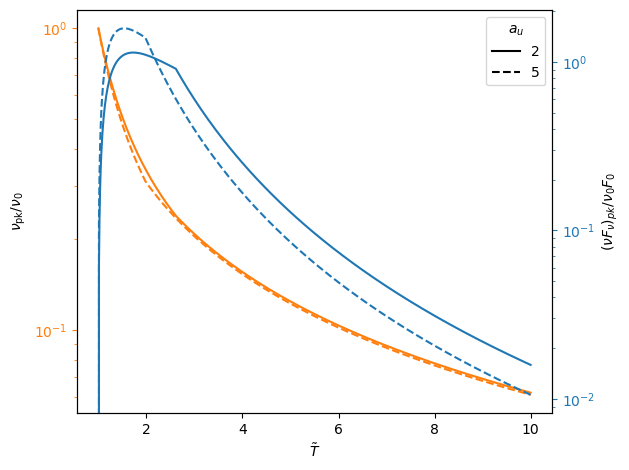

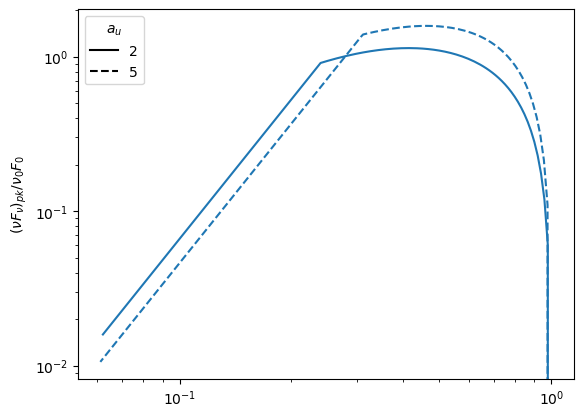

In [62]:
figT, ax1 = plt.subplots()
ax1.set_xlabel('$\\tilde{T}$')
ax1.set_ylabel('$\\nu_{\\rm pk}/\\nu_0$')
ax1.tick_params(which='both',axis='y', colors='C1')
ax2 = ax1.twinx()
ax2.tick_params(which='both',axis='y', colors='C0')
ax2.set_ylabel('$(\\nu F_\\nu)_{pk}/\\nu_0F_0$')

figCorr, ax3 = plt.subplots()
ax3.set_ylabel('$\\nu_{\\rm pk}/\\nu_0$')
ax3.set_ylabel('$(\\nu F_\\nu)_{pk}/\\nu_0F_0$')
linestyles = ['-', '--']
au_arr = [2, 5]
nu0_arr, F0_arr = [], []
for au, ls in zip(au_arr, linestyles):
  shells_params = [var for var in shells_params_0]
  shells_params[4] = shells_params[4]*au
  env = MyEnv(shells_params, assumptions)
  nu0, F0 = env.nu0_RS, env.F0_RS
  nu0_arr.append(nu0)
  F0_arr.append(F0)
  plot_fromparams(shells_params, figT, figCorr, ls)
  ax1.plot([], [], c='k', ls=ls, label=f'{au}')
  ax3.plot([], [], c='k', ls=ls, label=f'{au}')

ax1.legend(title='$a_u$')
ax3.legend(title='$a_u$')
figT.tight_layout()
figCorr.get_tight_layout()
print('Frequency and flux normalization ratio:')
print(nu0_arr[-1]/nu0_arr[0], F0_arr[-1]/F0_arr[0])